# Python中的接口与协议
协议在python就是非正式的接口，是让Python这种动态类型语言实现多态的方式（例如，实现了序列全部或部分协议的类型可在迭代时调用自身实现的“协议”），因此协议与集继承没有关系，一个类可能实现多个接口而让实例扮演多个角色。在Java这种静态类型语言中，多态靠的是运行时调用子类的具体实现而形成多态。

每个类实现或集成的公开属性包括特殊方法都是接口。而受保护的或私有属性不是接口。
# 序列
正式的Sequence类的接口
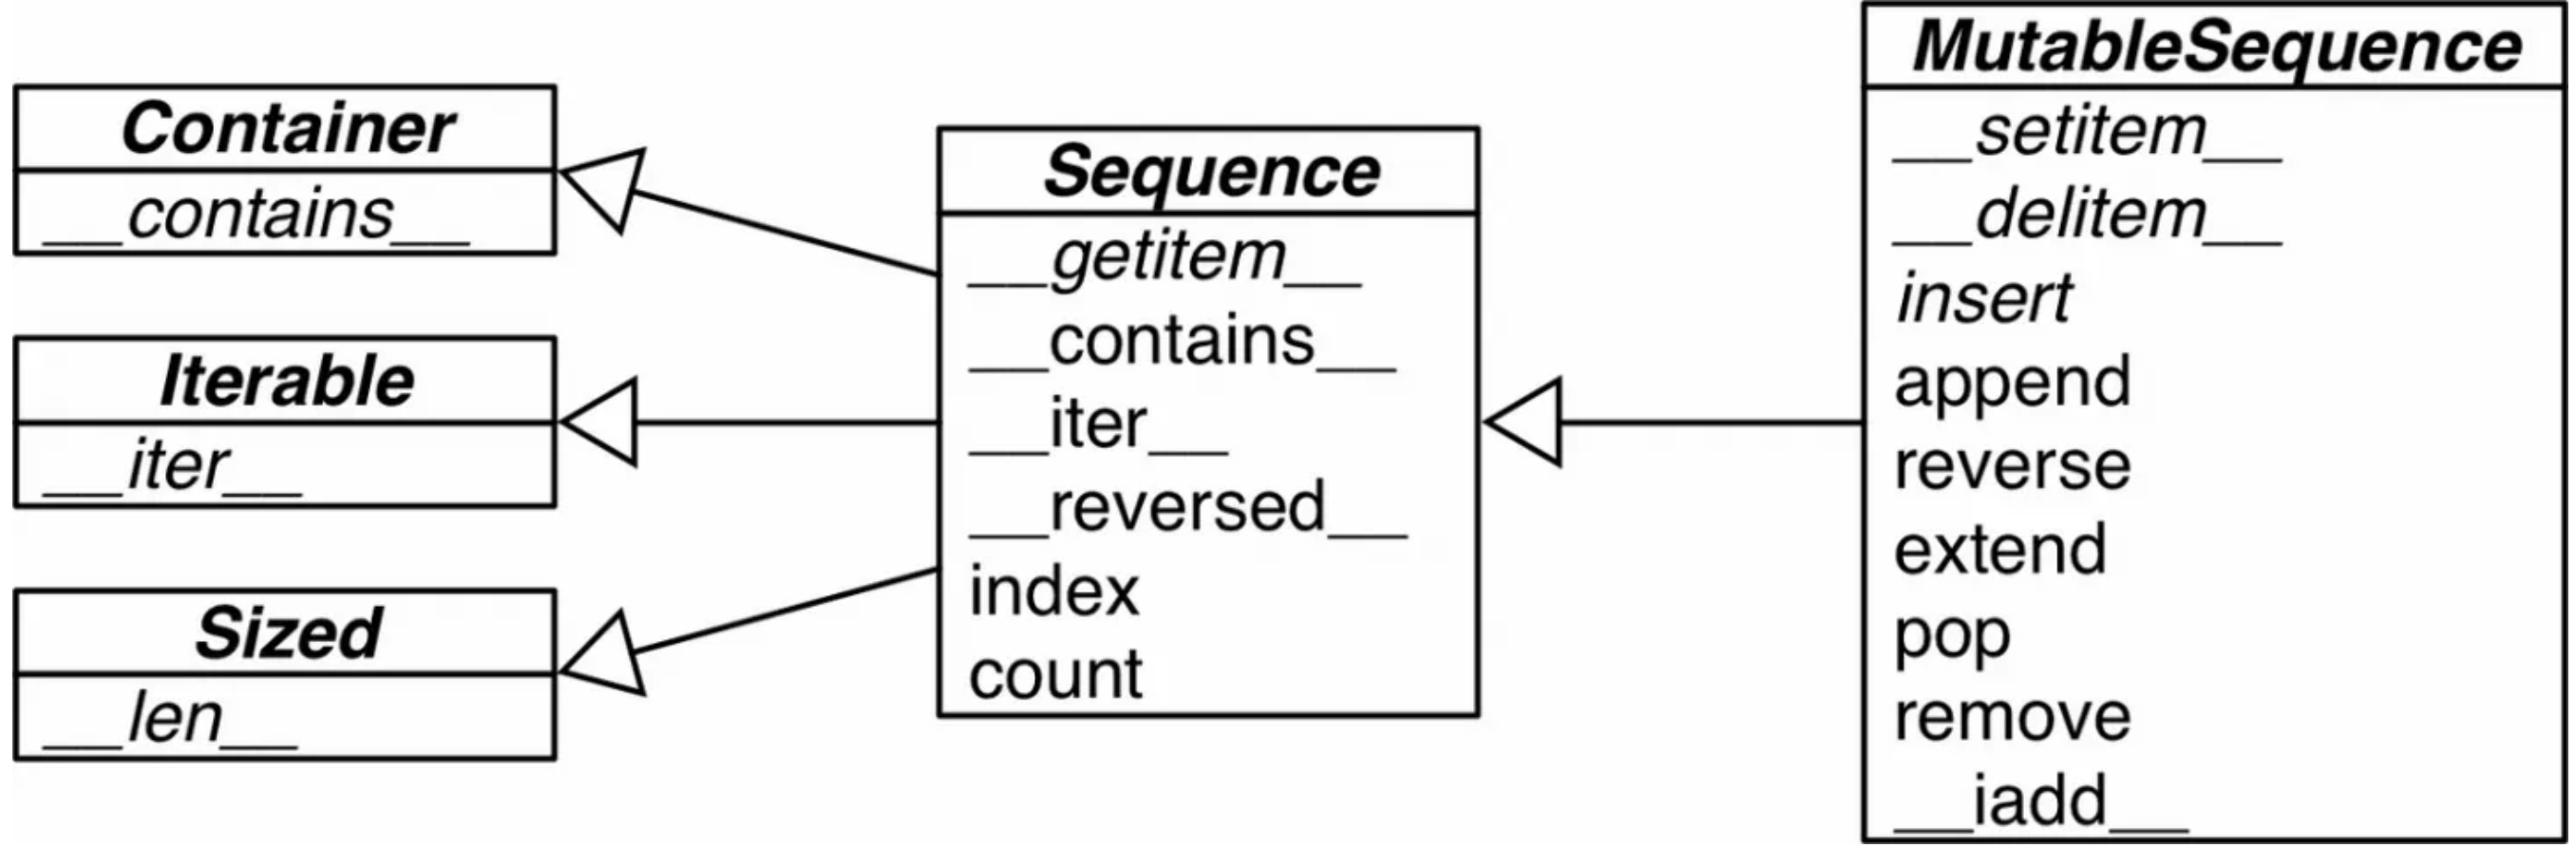
即便没有继承Sequence且仅仅实现了\__getitem__，Python仍然可以支持迭代（\__iter__）、in（\__contains__）的操作。Python可以仅仅利用\__getitem__实现\__iter__、\__contains__。Python对于序列的鸭子类型的容忍度是很高的。

In [2]:
class Foo:
    def __getitem__(self, pos):
        return range(0, 30, 10)[pos]
    
f = Foo()
print(f[1])

10


# 猴子补丁
在运行时给类的实例增添特殊方法以动态的给实例的类添加某种鸭子类型。以第一章的FrenchDeck为例

In [4]:
import collections
from random import shuffle
# 具名元组可用于构建仅含有属性的类，需指定类名和属性名list
Card = collections.namedtuple('Card', ['rank','suit'])
class FrenchDeck:
    ranks = [str(n) for n in range(2, 11)] + ['J','Q','K','A']
    suits = ['spades','diamonds','clubs','hearts']
    
    def __init__(self):
        self._cards = [Card(rank, suit) for suit in self.suits for rank in self.ranks]
    
    def __len__(self):
        return len(self._cards)
    
    def __getitem__(self, index):
        return self._cards[index]
    
deck = FrenchDeck()

def set_card(deck, position, card):
    deck._cards[position] = card
    
# 动态给类添加__setitem__特殊方法，以实现FrenchDeck的可变序列类型（至少__getitem__和__setitem__）。从而支持shuffle（就地）
FrenchDeck.__setitem__ = set_card
shuffle(deck)

print(deck[:5])

[Card(rank='8', suit='spades'), Card(rank='9', suit='hearts'), Card(rank='9', suit='diamonds'), Card(rank='3', suit='spades'), Card(rank='4', suit='diamonds')]


# 鸭子类型还是白鹅类型
## 鸭子类型
Python中，鸭子类型重点关注的是对象的行为，因此对象的类型无关紧要，只要实现了特定的协议即可。因此当着重于鸭子类型的时候代码汇中应当避免使用isinstance这种类型检查，转而把对象视为某种类型（如：序列）来使用。
## 白鹅类型
当希望定义一套较为严格意义上的类型时可能就需要用到抽象基类，任何继承或是声明为抽象基类子类的类必须满足抽象基类定义的标准。因此在搭建框架、定义组件标准时抽象基类更加常用。因此，首相积累适用于封装框架时引入一般性概念和抽象的，例如Sequence抽象基类对序列的严格概念定义。
## 实践建议
在判断类型的时候，如果希望对象强制执行了API契约可以使用isinstance进行类型检查，这对采用插入式架构的系统很有用，但在框架之外鸭子类型的风格更常见。比如当希望使用序列时，直接接收参数把它当做序列进行处理，如果参数不可迭代则调用立刻失败。

不要自己定义抽象基类，除非要构建一个允许用户扩展的框架。

In [7]:
# namedtuple创建场景，构造函数期待一个属性名field_names参数，该参数可接受以空格或逗号为分隔符的属性名字符串，也可以接受一个可迭代对象。
try:
    # 即便不是满足符合要求的字符串，后面的代码也可以直接处理是可迭代对象的情况，这里使用的是鸭子类型的思想而没有使用isinstance。
    field_names = field_names.replace(',', ' ').split()
except AttributeError:
    # 如果不是以空格或逗号为分隔符的属性名字符串，不做任何事。
    pass
# 直接尝试新创建tuple副本
field_names = tuple(field_names)

# 定义抽象基类的子类
利用现有的抽象基类实现子类必须实现全部的抽象方法。另外，导入模块时Python不会检查其中子类的抽象方法实现情况，在实例化时才会真正的检查。

一般而言，继承自抽象基类的具体方法可能由于“优先功能实现”的实现思想，在具体子类中的效率较低，此时子类可以以高效的方式重新实现（覆盖）。
# 标准库中的抽象基类
## collections.abc UML
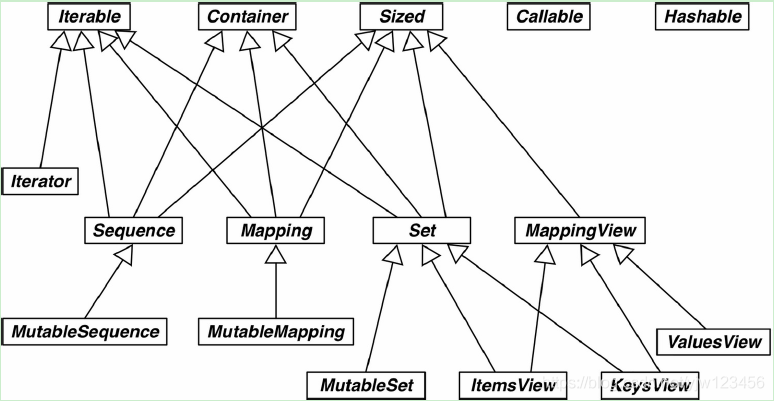
collections.abc的UML图中有很多多重继承。  
### Iterable、Container、Sized
各种集合应该继承这三个抽象基类，或者至少实现相关兼容协议（\__getitem__和\__len__）
### Sequence、Mapping、Set
主要是不可变集合类型，其都有可变集合类型的子类
### MappingView
映射的方法：items()、keys()、values()分别返回ItemsView、KeysView、ValueView视图对象。
### Callable、Hashable
主要用于isinstance判断对象是否可散列和可调用。
### Iterator
见Chapter14
## 数字
从抽象到具体依次为：Number->Complex->Real->Rational->Integral。如果想判断整数可以使用isinstance(x, numbers.Integral)，可以接受int、bool。如果想判断浮点数可以使用isinstance(x, numbers.Real)，此时可以判断bool、int、float、fractions.Fraction。

# 定义并使用抽象基类
以构建某种“随机无放回抽样机”比如宾果机、彩票球机的抽象接口（Tombola）为例，定义这种机器有四个标准（其中两个为抽象方法）  
load()：接受可迭代对象，将元素放入容器。  
pick()：无放回抽样   
loaded()：若容器中有元素则返回True  
inspect()：返回有序元组，元素为容器内元素（不会对容器内元素做修改）。  
构建两个具体子类：宾果机和乐透机。以及一个注册的虚拟子类。
#### 注册的虚拟子类，pyhton不会检查虚拟子类的正确实现与否，如有问题调用过程中会抛出。因此应当保证虚拟子类实现了抽象基类的全部抽象方法。
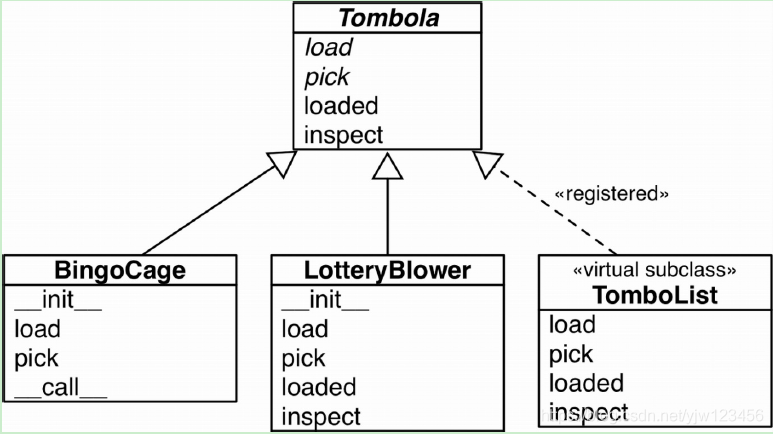

In [3]:
import abc
import random
# 自定义抽象基类继承abc.ABC
class Tombola(abc.ABC):
    # 抽象方法中也可有实现代码，子类可以使用super()进而调用抽象基类的抽象方法。abc.abstractmethod作用为强制子类覆盖该方法。
    @abc.abstractmethod
    def load(self, iterable):
        """load items form a Iterable obj"""
    
    @abc.abstractmethod
    def pick(self):
        """pick an item randomly,if the Tombola is empty, raise an LookUpError"""
        
    # 具体方法只能依赖抽象基类已有的接口、具体函数和属性，这里使用inspect()得到全部元素只为判断容器是否为空，效率很低（但能实现功能）。
    def loaded(self):
        return bool(self.inspect())
    
    # 使用pick和load实现的“笨拙”inspect。
    def inspect(self):
        items = []
        # 全部pick
        while True:
            try:
                items.append(self.pick())
            except LookupError:
                break
        # 重新load
        self.load(items)
        # 返回的元素时保证顺序的，无论pick的实现细节是什么。
        return tuple(sorted(items))
    
# 宾果机
class BingoCage(Tombola):
    # BingoCage选择使用继承到的耗时的loaded和笨拙的inspect方法。
    def __init__(self, items):
        self._randomizer = random.SystemRandom()
        self._items = []
        # 初始化时可完成load
        self.load(items)
        
    def load(self, items):
        self._items.extend(ltems)
        # 就地shuffle
        self._randomizer.shuffle(self._items)
        
    def pick(self):
        try:
            # 依靠load的shuffle，每次pop最后一个元素。
            return self._items.pop()
        except IndexError:
            raise LookupError('pick from empty BingoCage')
    
    def __call__(self):
        self.pick()
        
# 乐透机
class LotteryBlower(Tombola):
    def __init__(self, Iterable):
        # 初始化时当做可迭代对象
        self._items = list(Iterable)
        
    def load(self, Iterable):
        self._items.extend(Iterable)
        
    def pick(self):
        try:
            # 选择随机位置后pop。
            return self._items.pop(random.randrange(len(self._items)))
        except IndexError:
            raise LookupError('pick from empty LotteryBlower')
            
    # 重写方法，提供高效实现
    def loaded(self):
        return bool(self._items)
    
    # 重写方法，提供高效实现
    def inspect(self):
        # 返回的元素时保证顺序的。
        return tuple(sorted(self._items))
    
    def __call__(self):
        self.pick()
        
# 注册虚拟子类。pyhton不会检查虚拟子类的正确实现与否，如有问题调用过程中会抛出。
@Tombola.register
class TomboList(list):
    
    def pick(self):
        # 使用list内置__bool__
        if self:
            return self.pop(random.randrange(len(self)))
        else:
            raise LookupError('pick from empty TomboList')
    
    # load方法直接使用list父类的extend
    load = list.extend
    
    def loaded(self):
        return bool(self)
    
    def inspect(self):
        return tuple(sorted(self))

In [14]:
print(issubclass(TomboList, Tombola))
print(isinstance(TomboList(range(10)), Tombola))

True
True


# 继承情况内省
## 超类信息：\__mro__
类的继承关系存在于类的属性\__mro__（Method Resolution Order）,会列出当前类和其继承的超类。
## 子类
### \__subclasses__()
这个方法返回类的直接子类，不含虚拟子类。
### _abc_registry
这个属性只有抽象基类有，是一个WeakSet，保存着虚拟子类的弱引用。

In [16]:
# 可见TomboList的超类中的确没有Tombola类。因此没有从中继承到任何方法。
TomboList.__mro__

(__main__.TomboList, list, object)

In [26]:
# 空
print(TomboList.__subclasses__())
# list子类有TomboList
print(list.__subclasses__())
# Tombola虚拟子类
print(len(Tombola._abc_registry))

[]
[<class 'functools._HashedSeq'>, <class 'traceback.StackSummary'>, <class 'IPython.utils.text.SList'>, typing.List, typing.List[~AnyStr], typing.List[_ast.AST], <class 'prompt_toolkit.document._ImmutableLineList'>, <class 'prompt_toolkit.layout.utils._ExplodedList'>, <class 'parso.pgen2.parse.Stack'>, <class 'jedi.api.helpers.Stack'>, typing.List[str], <class 'dateutil.parser._parser._ymd'>, <class '__main__.TomboList'>]
1


# Python中使用register
内置类型tuple、str、range、memoryview都是使用register注册为Sequence的虚拟子类的。  
Sequence.register(tuple)  
Sequence.register(str)  
Sequence.register(range)  
Sequence.register(memoryview)  
# 子类钩子
通过实现特殊类方法\__subclasshook__来识别子类，此时子类无需继承超类也无需注册为虚拟子类。Python中仅仅Sized使用了该方法，因为\__len__方法的特殊性，可以认为拥有该函数的类都是Sized的子类。一般而言很难通过\__subclasshook__检查某个类是否包含名称符合的方法来判断该类是一个“合格”的子类，如果进一步用内省去校验该类方法的签名、其他属性等又很麻烦，因此很少使用。

In [6]:
# 抽象基类Sized源码
class Sized(abc.ABC):
    
    __slots__ = ()
    
    @abc.abstractmethod
    def __len__(self):
        return 0
    
    @classmethod
    def __subclasshook__(cls, C):
        # 只允许Sized使用
        if cls is Sized:
            # 传入的类对象自身或其超类中有__len__方法即可
            if any("__len__" in B.__dict__ for B in C.__mro__):
                return True
        return NotImplemented
    
class Struggle:
    def __len__(self):
        return 20
    
print(issubclass(Struggle, Sized))
print(isinstance(Struggle(), Sized))

True
True
